In [16]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

@dataclass
class ExperimentConfig:
    name: str
    classification_run: str
    seq2seq_run: str
    n_steps: int = 500
    chart_titles: Optional[List[str]] = None

class DataProcessor:
    def __init__(self, api: wandb.Api):
        self.api = api
        self.keys = [
            "validation_in_domain/accuracy",
            "training/accuracy",
        ]
    
    def get_run_data(self, run_path: str) -> pd.DataFrame:
        """Fetch and process run data from W&B."""
        run = self.api.run("philliplakaschus/grokking/" + run_path)
        
        history = list(run.scan_history())
        if not history:
            raise ValueError(f"No data found for run: {run_path}")
            
        available_columns = set(history[0].keys())
        requested_cols = ['Optimization Steps'] + self.keys
        cols_to_fetch = [col for col in requested_cols if col in available_columns]
        
        if not cols_to_fetch:
            raise ValueError(f"None of the required columns found in run: {run_path}")
            
        steps = pd.DataFrame([
            {k: step.get(k) for k in cols_to_fetch}
            for step in run.scan_history(cols_to_fetch)
        ])
        
        df = pd.DataFrame(index=steps['Optimization Steps'])
        for col in self.keys:
            if col in steps.columns:
                df[col] = steps[col].values
                
        return df
    
    @staticmethod
    def apply_ema(df: pd.DataFrame, alpha: float = 0.5) -> pd.DataFrame:
        """Apply Exponential Moving Average smoothing."""
        return df.ewm(alpha=alpha, adjust=False).mean()

class MultitaskPlotter:
    def __init__(self):
        # Define color schemes
        self.colors = {
            'classification': {
                'training': '#b00000',  # dark red
                'in_domain': '#fc0303',  # bright red
                'out_domain': '#ff6b6b'  # light red
            },
            'seq2seq': {
                'training': '#013491',  # dark blue
                'in_domain': '#0259fa',  # bright blue
                'out_domain': '#66a3ff'  # light blue
            }
        }
        
    def plot_model_curves(self, ax: plt.Axes, df: pd.DataFrame, 
                         model_type: str, label_prefix: str) -> None:
        """Plot curves for a single model type (classification or seq2seq)."""
        colors = self.colors[model_type]
        
        if 'training/accuracy' in df.columns:
            ax.plot(df.index, df['training/accuracy'],
                   color=colors['training'], linewidth=2,
                   label=f'{label_prefix} Training')
            
        if 'validation_in_domain/accuracy' in df.columns:
            ax.plot(df.index, df['validation_in_domain/accuracy'],
                   color=colors['in_domain'], linewidth=2,
                   label=f'{label_prefix} Validation')
            
        if 'validation_out_of_domain/accuracy' in df.columns:
            ax.plot(df.index, df['validation_out_of_domain/accuracy'],
                   color=colors['out_domain'], linewidth=2,
                   label=f'{label_prefix} Validation')
    
    def create_multitask_comparison(self, 
                                  classification_runs: Dict[str, pd.DataFrame],
                                  seq2seq_runs: Dict[str, pd.DataFrame],
                                  run_ids: List[str] = ['run1', 'run2'],
                                  chart_titles: Optional[List[str]] = None) -> None:
        """Create side-by-side plots comparing multitask settings."""
        plt.style.use('default')
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=150)
        
        # Default titles if none provided
        if chart_titles is None:
            chart_titles = ['Multitask Setting 1', 'Multitask Setting 2']
        
        # Plot each run on its respective axis
        for idx, run_id in enumerate(run_ids):
            ax = ax1 if idx == 0 else ax2
            
            # Plot classification curves
            if run_id in classification_runs:
                self.plot_model_curves(ax, classification_runs[run_id], 
                                    'classification', 'Class')
            
            # Plot seq2seq curves
            if run_id in seq2seq_runs:
                self.plot_model_curves(ax, seq2seq_runs[run_id], 
                                    'seq2seq', 'Seq2Seq')
            
            # Style the subplot
            ax.set_facecolor('#f8f9fa')
            ax.grid(True, which='major', linestyle='--', alpha=0.7, color='#cccccc')
            ax.set_xlabel('Optimization Steps', fontsize=12, fontweight='bold')
            ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
            ax.set_title(chart_titles[idx], fontsize=14, fontweight='bold', pad=20)
            ax.tick_params(axis='both', which='major', labelsize=10)
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
            ax.set_ylim(-0.05, 1.05)
            
            # Move legend to bottom right inside the plot
            ax.legend(loc='lower right', frameon=True, fancybox=True, 
                     shadow=True, fontsize=10)
        
        fig.patch.set_facecolor('#ffffff')
        plt.tight_layout()
        return fig, [ax1, ax2]

# Example usage
def run_multitask_comparison(api: wandb.Api,
                           classification_urls: Dict[str, str],
                           seq2seq_urls: Dict[str, str]) -> None:
    processor = DataProcessor(api)
    plotter = MultitaskPlotter()
    
    # Process all runs
    classification_runs = {}
    seq2seq_runs = {}
    
    for run_id, url in classification_urls.items():
        df = processor.get_run_data(url)
        classification_runs[run_id] = processor.apply_ema(df)
        
    for run_id, url in seq2seq_urls.items():
        df = processor.get_run_data(url)
        seq2seq_runs[run_id] = processor.apply_ema(df)
    
    # Create plots
    plotter.create_multitask_comparison(
        classification_runs,
        seq2seq_runs,
        chart_titles=['Multitask Setting 1', 'Multitask Setting 2']
    )
    plt.show()

# Multitask Results

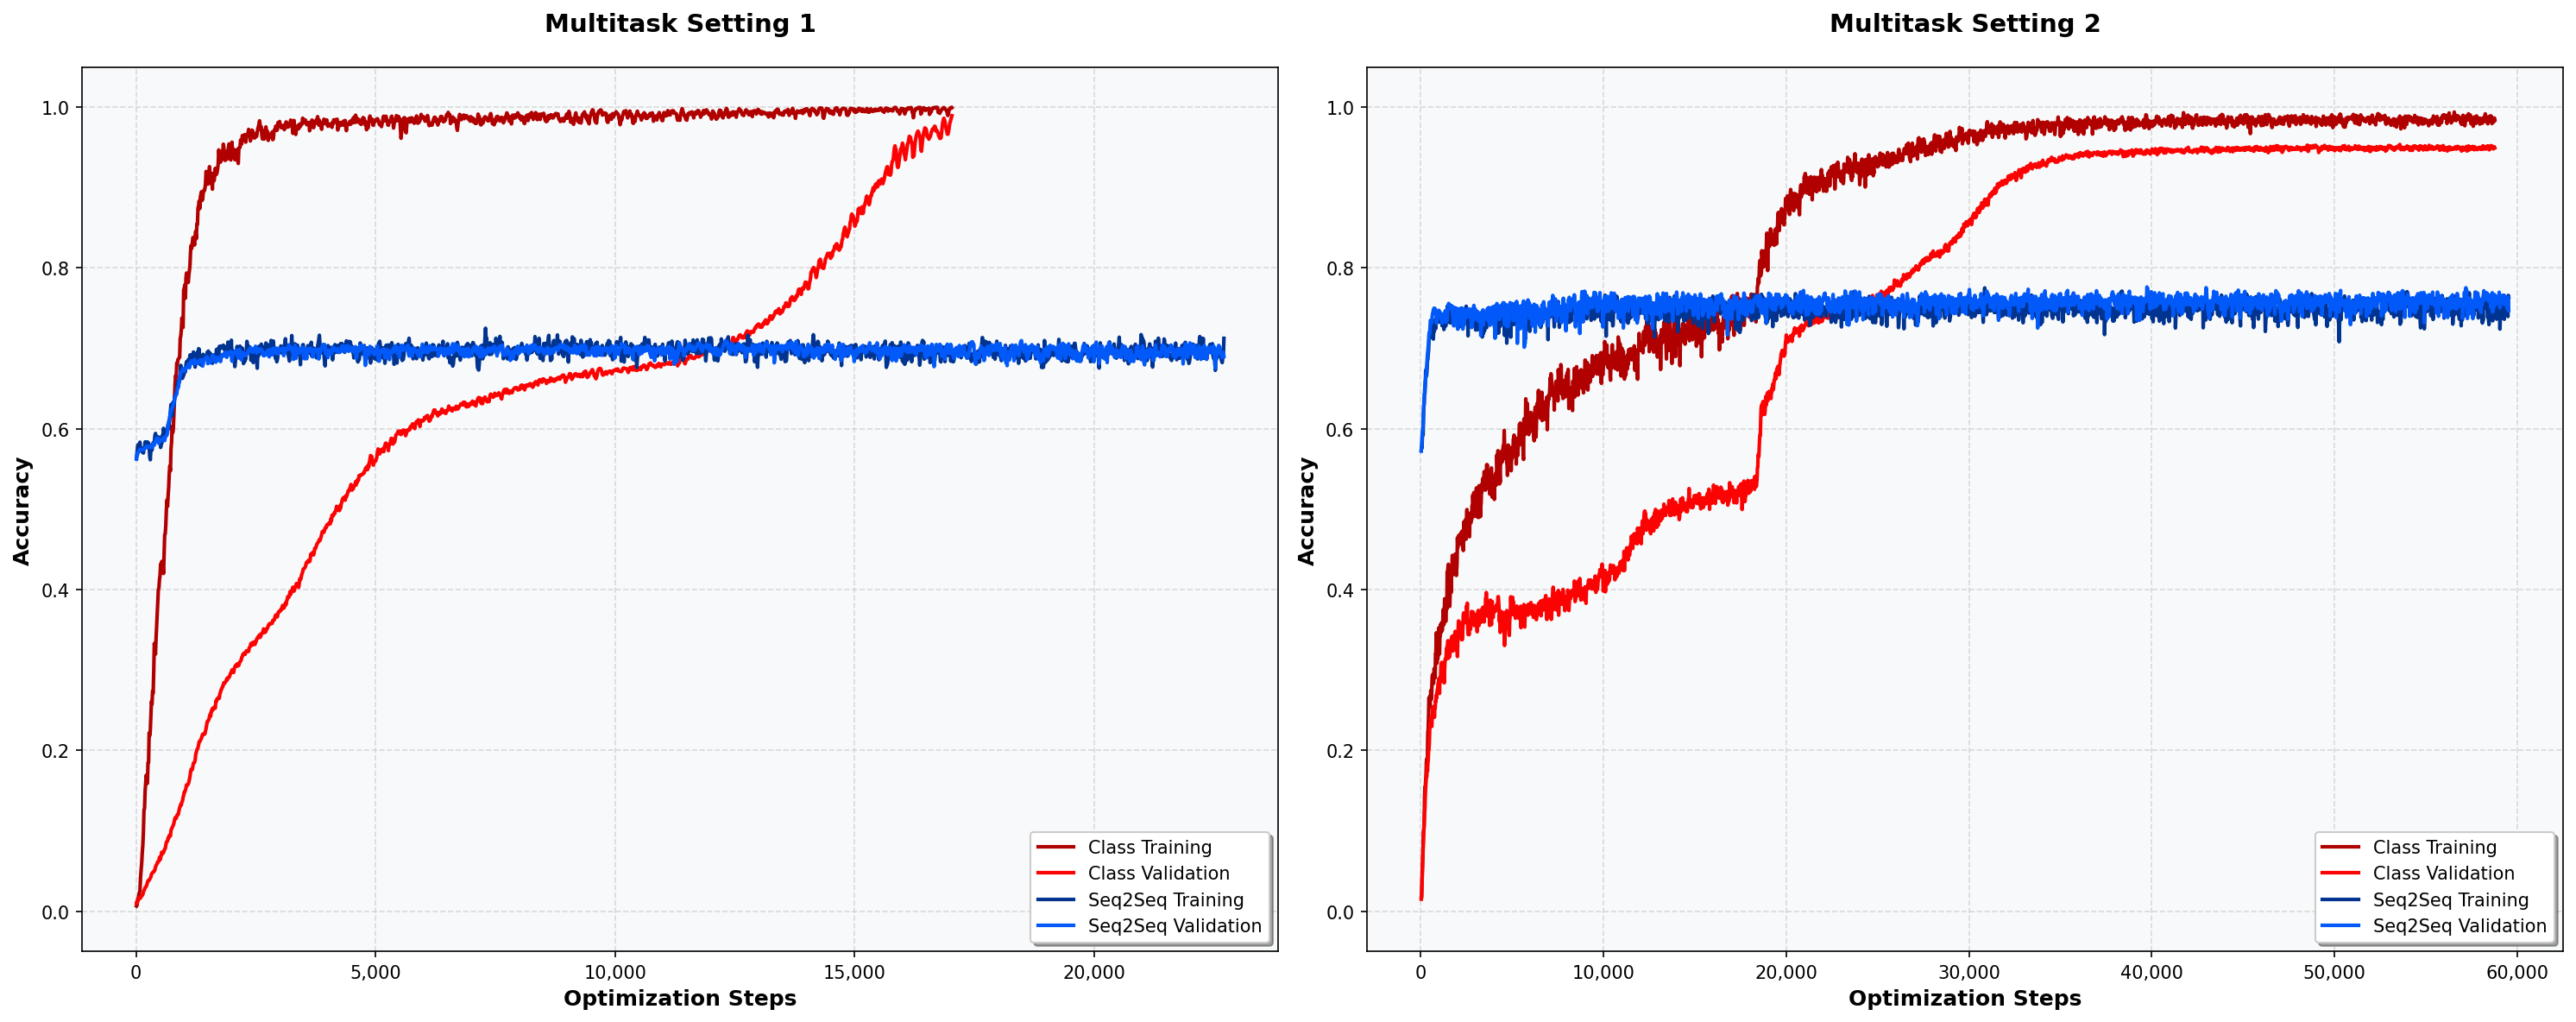

In [20]:
# Run the comparison - 4 Layers
api = wandb.Api()
run_multitask_comparison(
    api,
    classification_urls={"run1": "63iq5tir", "run2": "oksbva21"},
    seq2seq_urls={"run1": "pres5dy2", "run2": "g8zlvvxu"}
)